In [1]:
from env import host, user, password
import acquire
import prepare
import wrangle

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [3]:
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, explained_variance_score

# Acquire

In [4]:
def get_connection(db_name):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    '''
    from env import host, user, password
    return f'mysql+pymysql://{user}:{password}@{host}/{db_name}'

In [5]:
def get_zillow_file():
    if os.path.isfile('zillow.csv'):
        df = pd.read_csv('zillow.csv', index_col=0)
    
    else:
        df = get_zillow()
        df.to_csv('zillow.csv')
    
    return df

In [6]:
df = get_zillow_file()

# Prepare

In [7]:
df.head()

,calculatedfinishedsquarefeet,bedroomcnt,bathroomcnt,taxvaluedollarcnt,taxamount,yearbuilt,fips,parcelid
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756


In [8]:
#calculate tax rate
df['tax_rate'] =df['taxamount']/  df['taxvaluedollarcnt']

In [9]:
#rename columns to make more legible
df = df.rename(columns={"calculatedfinishedsquarefeet": "total_sqft", "bedroomcnt": "bedrooms", "bathroomcnt": "bathrooms", "taxvaluedollarcnt": "value_assessed", "taxamount": "tax_amount", "yearbuilt": "year_built", "fips": "county_code" })

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28345 non-null  float64
 1   bedrooms        28418 non-null  float64
 2   bathrooms       28418 non-null  float64
 3   value_assessed  28417 non-null  float64
 4   tax_amount      28417 non-null  float64
 5   year_built      28322 non-null  float64
 6   county_code     28418 non-null  float64
 7   parcelid        28418 non-null  int64  
 8   tax_rate        28416 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [11]:
#28,418 entries
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28418 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28345 non-null  float64
 1   bedrooms        28418 non-null  float64
 2   bathrooms       28418 non-null  float64
 3   value_assessed  28417 non-null  float64
 4   tax_amount      28417 non-null  float64
 5   year_built      28322 non-null  float64
 6   county_code     28418 non-null  float64
 7   parcelid        28418 non-null  int64  
 8   tax_rate        28416 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [12]:
#check for duplicates
df.drop_duplicates(inplace=True)

In [13]:
#28,392 entries (removed 26 duplicates)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28392 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28321 non-null  float64
 1   bedrooms        28392 non-null  float64
 2   bathrooms       28392 non-null  float64
 3   value_assessed  28391 non-null  float64
 4   tax_amount      28391 non-null  float64
 5   year_built      28298 non-null  float64
 6   county_code     28392 non-null  float64
 7   parcelid        28392 non-null  int64  
 8   tax_rate        28390 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [14]:
# replace nan values
df = df.replace(r'^\s*$', np.nan, regex=True)
df

,total_sqft,bedrooms,bathrooms,value_assessed,tax_amount,year_built,county_code,parcelid,tax_rate
0,1316.0,3.0,2.0,205123.0,2627.48,1923.0,6037.0,11721753,0.012809
1,1458.0,3.0,2.0,136104.0,2319.90,1970.0,6037.0,11289917,0.017045
2,1421.0,2.0,1.0,35606.0,543.69,1911.0,6037.0,11705026,0.015270
3,2541.0,4.0,3.0,880456.0,9819.72,2003.0,6059.0,14269464,0.011153
4,1491.0,3.0,2.0,107110.0,1399.27,1955.0,6037.0,11446756,0.013064
...,...,...,...,...,...,...,...,...,...
28413,2634.0,6.0,2.0,878190.0,12766.88,1921.0,6037.0,11991766,0.014538
28414,1187.0,4.0,1.5,465999.0,5552.68,1959.0,6059.0,14011468,0.011916
28415,3015.0,5.0,3.0,852813.0,11662.88,2002.0,6059.0,14453399,0.013676
28416,2992.0,5.0,3.0,1120000.0,13663.03,1977.0,6037.0,11128688,0.012199


In [15]:
#drop na values 
df = df.dropna()
df.isnull().sum()

total_sqft        0
bedrooms          0
bathrooms         0
value_assessed    0
tax_amount        0
year_built        0
county_code       0
parcelid          0
tax_rate          0
dtype: int64

In [16]:
#after dropping na- 24610 entries left ( ~4000 dropped)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28292 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      28292 non-null  float64
 1   bedrooms        28292 non-null  float64
 2   bathrooms       28292 non-null  float64
 3   value_assessed  28292 non-null  float64
 4   tax_amount      28292 non-null  float64
 5   year_built      28292 non-null  float64
 6   county_code     28292 non-null  float64
 7   parcelid        28292 non-null  int64  
 8   tax_rate        28292 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 2.2 MB


In [17]:
df.nunique()

total_sqft         4052
bedrooms             13
bathrooms            19
value_assessed    22854
tax_amount        27845
year_built          131
county_code           3
parcelid          28292
tax_rate          28255
dtype: int64

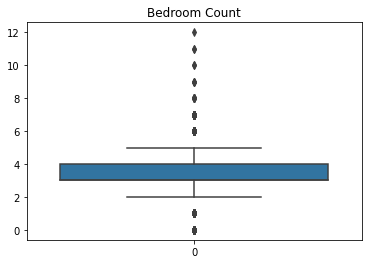

In [18]:
sns.boxplot(data=df.bedrooms)
plt.title('Bedroom Count')
plt.show()

#outliers can be seen here

In [19]:
df.bedrooms.describe()

count    28292.000000
mean         3.305988
std          0.936688
min          0.000000
25%          3.000000
50%          3.000000
75%          4.000000
max         12.000000
Name: bedrooms, dtype: float64

In [20]:
#finding IQR of bedrooms to find outliers
q1_bed = df['bedrooms'].quantile(0.25)
q3_bed = df['bedrooms'].quantile(0.75)
iqr_bed = q3_bed - q1_bed
iqr_bed, q3_bed, q1_bed

(1.0, 4.0, 3.0)

In [21]:
lowerbound_bed = q1_bed - (1.5 * iqr_bed)
upperbound_bed = q3_bed + (1.5 * iqr_bed)
print(f'Lower bounds for bedroom count is: {lowerbound_bed}')
print(f'Upprt bounds for bedroom count is: {upperbound_bed}')

Lower bounds for bedroom count is: 1.5
Upprt bounds for bedroom count is: 5.5


In [22]:
#remove outliers for bedrooms
df= df[df.bedrooms > lowerbound_bed]
df= df[df.bedrooms < upperbound_bed]

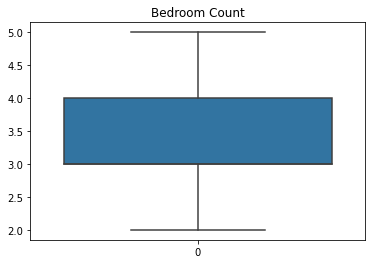

In [23]:
#show outliers have been removed
sns.boxplot(data=df.bedrooms)
plt.title('Bedroom Count')
plt.show()

In [24]:
#descriptive stats for bedrooms, help understand outliers
df.bathrooms.describe()

count    27530.000000
mean         2.299491
std          0.950588
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: bathrooms, dtype: float64

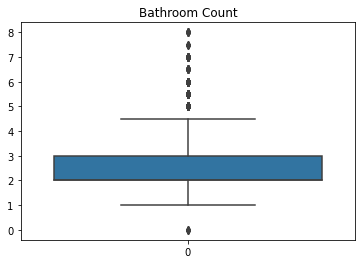

In [25]:
#visualize outliers
sns.boxplot(data=df.bathrooms)
plt.title('Bathroom Count')
plt.show()

In [26]:
#finding IQR of bathrooms to find outliers
q1_bath = df['bathrooms'].quantile(0.25)
q3_bath = df['bathrooms'].quantile(0.75)
iqr_bath = q3_bath - q1_bath

iqr_bath, q3_bath, q1_bath

(1.0, 3.0, 2.0)

In [27]:
lowerbound_bath = q1_bath - (1.5 * iqr_bath)
upperbound_bath = q3_bath + (1.5 * iqr_bath)
lowerbound_bath, upperbound_bath
print(f'Lower bounds for bathroom count is: {lowerbound_bath}')
print(f'Upper bounds for bathroom count is: {upperbound_bath}')

Lower bounds for bathroom count is: 0.5
Upper bounds for bathroom count is: 4.5


In [28]:
#remove outliers for bathroom
df= df[df.bathrooms > lowerbound_bath]
df= df[df.bathrooms < upperbound_bath]

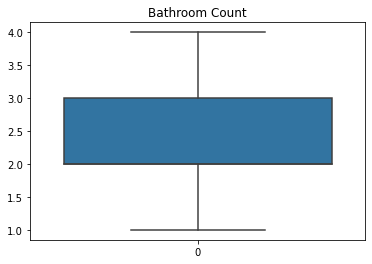

In [29]:
#show outliers have been removed
sns.boxplot(data=df.bathrooms)
plt.title('Bathroom Count')
plt.show()

In [30]:
df.value_assessed.describe()

count    2.648000e+04
mean     4.618069e+05
std      4.628791e+05
min      1.000000e+03
25%      1.921658e+05
50%      3.654890e+05
75%      5.840095e+05
max      1.360010e+07
Name: value_assessed, dtype: float64

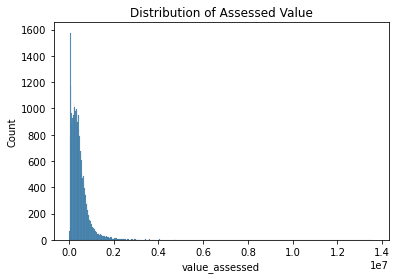

In [31]:
#taxvalue distribution
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Assessed Value')
plt.show()

In [32]:
#finding IQR of Tax Value to find outliers
q1_tax = df['value_assessed'].quantile(0.25)
q3_tax = df['value_assessed'].quantile(0.75)
iqr_tax = q3_tax- q1_tax
iqr_tax, q3_tax, q1_tax

(391843.75, 584009.5, 192165.75)

In [33]:
lowerbound_tax = q1_tax - (1.5 * iqr_tax)
upperbound_tax = q3_tax + (1.5 * iqr_tax)
print(f'Lower bounds for Assessed Value is: {lowerbound_tax}')
print(f'Upper bounds for Assessed Value is: {upperbound_tax}')

Lower bounds for Assessed Value is: -395599.875
Upper bounds for Assessed Value is: 1171775.125


In [34]:
#remove outliers for tax
df= df[df.value_assessed > lowerbound_tax]
df= df[df.value_assessed < upperbound_tax]

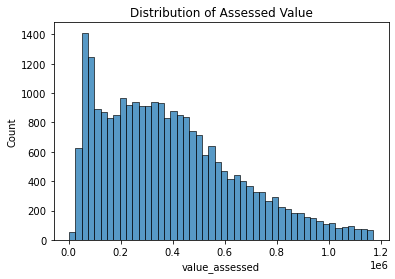

In [35]:
#taxvalue with outliers removed
sns.histplot(data=df.value_assessed)
plt.title('Distribution of Assessed Value')
plt.show()

In [36]:
df.total_sqft.describe()

count    25142.000000
mean      1750.113197
std        668.999538
min        326.000000
25%       1253.250000
50%       1600.000000
75%       2118.000000
max       6756.000000
Name: total_sqft, dtype: float64

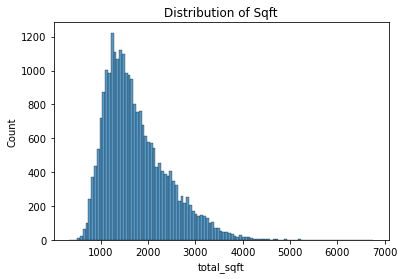

In [37]:
#sqft distribution
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [38]:
#finding IQR of Tax Value to find outliers
q1_sqft = df['total_sqft'].quantile(0.25)
q3_sqft = df['total_sqft'].quantile(0.75)
iqr_sqft = q3_sqft - q1_sqft
iqr_sqft, q3_sqft, q1_sqft

(864.75, 2118.0, 1253.25)

In [39]:
lowerbound_sqft = q1_sqft - (1.5 * iqr_sqft)
upperbound_sqft = q3_sqft + (1.5 * iqr_sqft)
print(f'Lower bounds for Square Feet  is: {lowerbound_sqft}')
print(f'Upper bounds for Square Feet is: {upperbound_sqft}')

Lower bounds for Square Feet  is: -43.875
Upper bounds for Square Feet is: 3415.125


In [40]:
#remove outliers for sqft
df= df[df.total_sqft > lowerbound_sqft]
df= df[df.total_sqft < upperbound_sqft]

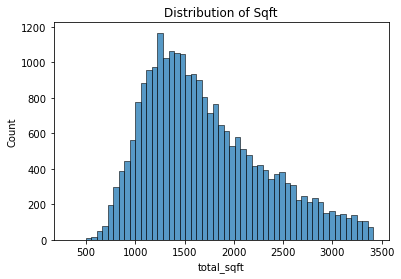

In [41]:
#sqft distribution with outliers removed
sns.histplot(data=df.total_sqft)
plt.title('Distribution of Sqft')
plt.show()

In [42]:
#shape after dropping outliers
df.shape

(24610, 9)

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24610 entries, 0 to 28417
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_sqft      24610 non-null  float64
 1   bedrooms        24610 non-null  float64
 2   bathrooms       24610 non-null  float64
 3   value_assessed  24610 non-null  float64
 4   tax_amount      24610 non-null  float64
 5   year_built      24610 non-null  float64
 6   county_code     24610 non-null  float64
 7   parcelid        24610 non-null  int64  
 8   tax_rate        24610 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 1.9 MB


In [44]:
#split data
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.zillow_split(df, 'value_assessed')

train -> (13781, 9)
validate -> (5907, 9)
test -> (4922, 9)


In [45]:
train.columns

Index(['total_sqft', 'bedrooms', 'bathrooms', 'value_assessed', 'tax_amount',
       'year_built', 'county_code', 'parcelid', 'tax_rate'],
      dtype='object')

<hr style="border:2px solid black"> </hr>

In [46]:
numeric_cols= ['total_sqft', 'tax_rate', 'year_built']

In [47]:
#minmaxscaler
X_train_scaled, X_validate_scaled, X_test_scaled = wrangle.min_max_scale(X_train, X_validate, X_test, numeric_cols)

In [48]:
X_train.isnull().sum()

total_sqft     0
bedrooms       0
bathrooms      0
tax_amount     0
year_built     0
county_code    0
parcelid       0
tax_rate       0
dtype: int64

# Explore

In [49]:
zillow_correlation = train.corr()

In [50]:
#this shows that total_sqft is closely correlated to value_assessed
zillow_corr = zillow_correlation['value_assessed'].sort_values(ascending=False)
zillow_corr

value_assessed    1.000000
tax_amount        0.960258
total_sqft        0.453666
bathrooms         0.369707
year_built        0.227459
bedrooms          0.204167
county_code       0.124354
parcelid          0.076986
tax_rate         -0.175648
Name: value_assessed, dtype: float64

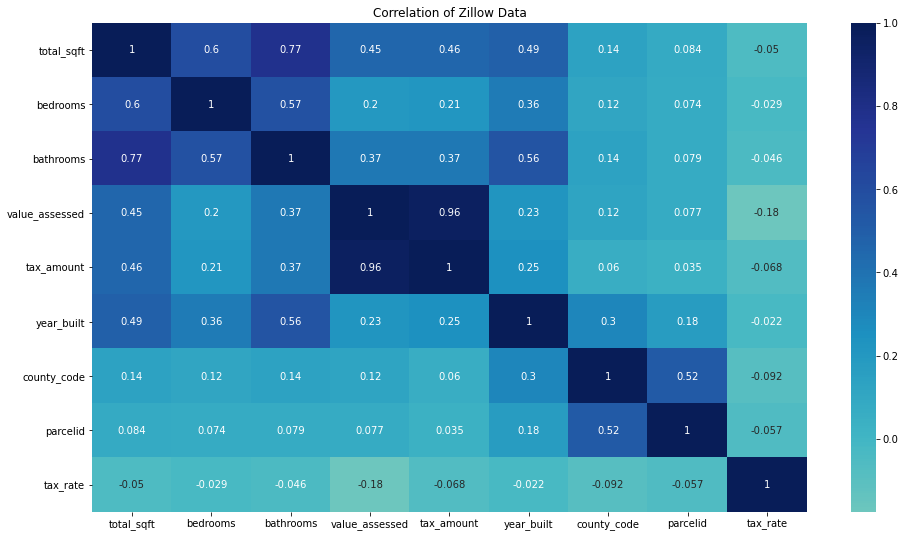

In [51]:
#heatmap to show correlation of all data
plt.figure(figsize=(16,9))

sns.heatmap(train.corr(), cmap='YlGnBu', center=0, annot=True)

plt.title('Correlation of Zillow Data')

plt.show()

### Feature Engineering

In [52]:
#RFE
lm = LinearRegression()
rfe = RFE(estimator=lm, n_features_to_select=2)
rfe.fit_transform(X_train_scaled, y_train)
feature_mask_rank = rfe.ranking_
pd.Series(dict(zip(X_train.columns, rfe.ranking_))).sort_values()

total_sqft    1
bedrooms      1
bathrooms     2
dtype: int64

In [53]:
#SelectKBest model 
f_selector = SelectKBest(score_func=f_regression, k=2)
#fit the model
f_selector.fit(X_train, y_train)
mask = f_selector.get_support()
X_train.columns[mask]

Index(['total_sqft', 'tax_amount'], dtype='object')

<hr style="border:2px solid black"> </hr>

### Hypothesis for T-Test (cont vs discrete)
$H_0$: There is a relationship between value_assessed and bedroom count
- value_assessed == bedroom count
<br>

$H_a$: There is no relationship between value_assessed and bedroom count
- value_assessed != bedroom count

In [54]:
#set alpha
alpha = .05

In [55]:
# sample size, must be more then 30 to meet assumption
train.value_assessed.count(), train.bedrooms.count()

(13781, 13781)

In [56]:
#check variance
train.value_assessed.var(), train.bedrooms.var()

#this shows not equal varient

(62595513701.88162, 0.6121007141677633)

In [57]:
#t-test on entire train set
t, p = stats.ttest_ind(train.value_assessed,train.bedrooms, equal_var=False)

In [58]:
t, p, alpha

(177.91120198112105, 0.0, 0.05)

In [59]:
p <alpha

True

In [60]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we fail to reject our null hypothesis')

We calculate a t of 177.911202 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we fail to reject our null hypothesis


______________________________________

### 2nd Hypothesis for T-Test (cont vs discrete)
$H_0$: There is a relationship between value_assessed and number of bathrooms
- value_assessed == bathroom count
<br>

$H_a$: There is no relationship between value_assessed and number of bathrooms
- value_assessed != bathroom count

In [61]:
#set alpha
alpha = .05

In [62]:
# sample size, must be more then 30 to meet assumption
train.value_assessed.count(), train.bathrooms.count()

(13781, 13781)

In [63]:
#check variance
train.value_assessed.var(), train.bathrooms.var()

#this shows not equal varient

(62595513701.88162, 0.5141750900384159)

In [64]:
#t-test on entire train set
t, p = stats.ttest_ind(train.value_assessed,train.bathrooms, equal_var=False)

In [65]:
print(f'We calculate a t of {t:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we fail to reject our null hypothesis')

We calculate a t of 177.911715 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we fail to reject our null hypothesis


<hr style="border:2px solid black"> </hr>

### Hypothesis for Pearson's Correlation Test (cont vs cont)

$H_0$: There is no relationship between total_sqft and value_assessed
- total_sqft != value_assessed 
<br>

$H_a$: There is a relationship between total_sqft and value_assessed
- total_sqft == value_assessed

In [66]:
#pearsons correlation on entire train set
#number of rows
n = train.shape[0] 

#degrees of freedom- how much the data can vary
deg_f = n-2 

#confidence interval (!)
conf_in = 0.95

alpha = 1- conf_in

In [67]:
x= train.total_sqft
y= train.value_assessed

In [68]:
r, p = stats.pearsonr(x,y)

In [69]:
p < alpha

True

In [70]:
print(f'We calculate a pearson r of {r:3f} and a statistical certainty p of {p:4f}')
print(f'Because p {p:4f} < α  {alpha:4f}, we can reject our null hypothesis')

We calculate a pearson r of 0.453666 and a statistical certainty p of 0.000000
Because p 0.000000 < α  0.050000, we can reject our null hypothesis


<hr style="border:2px solid black"> </hr>

In [71]:
X_train.head()

,total_sqft,bedrooms,bathrooms,tax_amount,year_built,county_code,parcelid,tax_rate
11646,1060.0,3.0,1.0,2114.08,1950.0,6037.0,12475415,0.012821
3981,3410.0,3.0,3.0,9047.20,1991.0,6059.0,14498746,0.010243
20964,2590.0,3.0,3.0,4175.85,2004.0,6037.0,11215841,0.025229
11000,2232.0,4.0,3.0,2711.28,1972.0,6037.0,11187703,0.016116
11701,2248.0,4.0,3.0,6359.13,1990.0,6037.0,11345383,0.013420


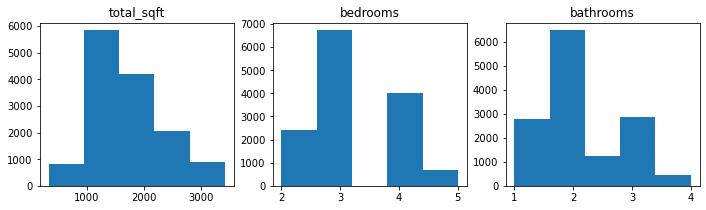

In [72]:
# Plot the distributions
plt.figure(figsize=(16, 3))

# List of columns
cols = ['total_sqft', 'bedrooms', 'bathrooms']

for i, col in enumerate(cols):

    # i starts at 0, but plot nos should start at 1
    plot_number = i + 1 

    # Create subplot.
    plt.subplot(1,4, plot_number)

    # Title with column name.
    plt.title(col)

    # Display histogram for column.
    train[col].hist(bins=5)

    # Hide gridlines.
    plt.grid(False)

<hr style="border:2px solid black"> </hr>

# Model

In [73]:
# first number in fips is state
# second 2 numbers in fips is county

In [74]:
#create a baseline
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [75]:
# 1. Predict assessed_value_pred_mean
value_assessed_pred_mean = y_train['value_assessed'].mean()
y_train['value_assessed_pred_mean'] = value_assessed_pred_mean
y_validate['value_assessed_pred_mean'] = value_assessed_pred_mean

In [76]:
# 2. RMSE of fertility_pred_mean
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_mean)**(1/2)
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  250181.88 
Validate/Out-of-Sample:  249144.58


In [77]:
metric_df = pd.DataFrame(data=[{
    'model': 'mean_baseline',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_mean)}])

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.0


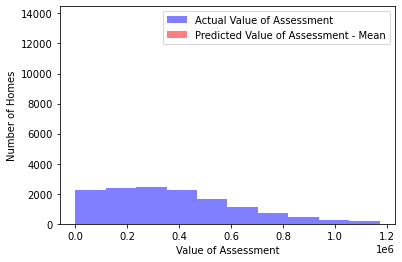

In [78]:
# plot to visualize actual vs predicted. 
plt.hist(y_train.value_assessed, color='blue', alpha=.5, label="Actual Value of Assessment")
plt.hist(y_train.value_assessed_pred_mean, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Value of Assessment - Mean")
plt.xlabel("Value of Assessment")
plt.ylabel("Number of Homes")
plt.legend()
plt.show()

<hr style="border:2px solid black"> </hr>

## Linear Regression Model

In [79]:
#create the model 
lm = LinearRegression(normalize=True)

#fit
lm.fit(X_train_scaled, y_train.value_assessed)

LinearRegression(normalize=True)

In [80]:
# predict train
y_train['value_assessed_pred_lm'] = lm.predict(X_train_scaled)

In [81]:
# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_lm)**(1/2)

In [82]:
rmse_train

219633.31414069078

In [83]:
# predict validate
y_validate['value_assessed_pred_lm'] = lm.predict(X_validate_scaled)

In [84]:
# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_lm)**(1/2)

In [85]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  219633.31414069078 
Validation/Out-of-Sample:  217307.81037150015


In [86]:
metric_df = metric_df.append(
    {
    'model': 'LinearRegression',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_lm)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.00000
1,LinearRegression,219633.314141,217307.810372,0.23923


<hr style="border:2px solid black"> </hr>

## LassoLars Model

In [87]:
# create the model object
lars = LassoLars(alpha= 4)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled, y_train.value_assessed)

# predict train
y_train['value_assessed_pred_lars'] = lars.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_lars)**(1/2)

# predict validate
y_validate['value_assessed_pred_lars'] = lars.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  219634.44449508417 
Validation/Out-of-Sample:  217358.55740066958


In [88]:
metric_df = metric_df.append(
    {
    'model': 'LassoLars alpha 4',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_lars)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.000000
1,LinearRegression,219633.314141,217307.810372,0.239230
2,LassoLars alpha 4,219634.444495,217358.557401,0.238875


<hr style="border:2px solid black"> </hr>

## Tweedie Regressor Model

In [89]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled, y_train.value_assessed)

# predict train
y_train['value_assessed_pred_glm'] = glm.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.value_assessed, y_train.value_assessed_pred_glm)**(1/2)

# predict validate
y_validate['value_assessed_pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.value_assessed, y_validate.value_assessed_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  198917.81206926462 
Validation/Out-of-Sample:  196721.81118170277


In [90]:
metric_df = metric_df.append(
    {
    'model': 'TweedieRegressor power 1',
    'rmse_train': rmse_train,
    'rmse_validate': rmse_validate,
    'r^2_validate': explained_variance_score(y_validate.value_assessed, y_validate.value_assessed_pred_glm)}, ignore_index=True)

metric_df

,model,rmse_train,rmse_validate,r^2_validate
0,mean_baseline,250181.876924,249144.577291,0.000000
1,LinearRegression,219633.314141,217307.810372,0.239230
2,LassoLars alpha 4,219634.444495,217358.557401,0.238875
3,TweedieRegressor power 1,198917.812069,196721.811182,0.376556


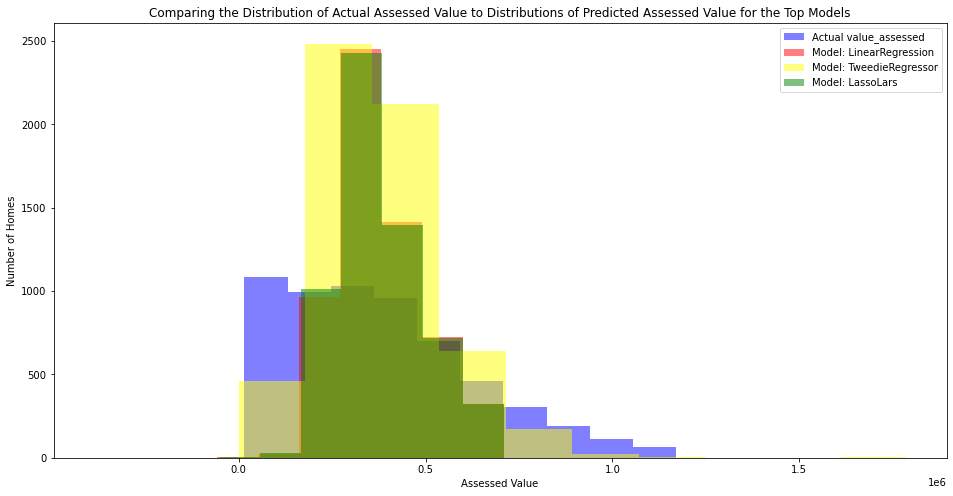

In [93]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.value_assessed, color='blue', alpha=.5, label="Actual value_assessed")
plt.hist(y_validate.value_assessed_pred_lm, color='red', alpha=.5, label="Model: LinearRegression")
plt.hist(y_validate.value_assessed_pred_glm, color='yellow', alpha=.5, label="Model: TweedieRegressor")
plt.hist(y_validate.value_assessed_pred_lars, color='green', alpha=.5, label="Model: LassoLars")
plt.xlabel("Assessed Value")
plt.ylabel("Number of Homes")
plt.title("Comparing the Distribution of Actual Assessed Value to Distributions of Predicted Assessed Value for the Top Models")
plt.legend()
plt.show()

In [94]:
y_test = pd.DataFrame(y_test)

# predict on test
y_test['value_assessed_pred_lm'] = lm.predict(X_test_scaled)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.value_assessed, y_test.value_assessed_pred_lm)**(1/2)

print("RMSE for OLS Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for OLS Model using LinearRegression
Out-of-Sample Performance:  216636.32445090226
